## Notebook EDA

## Sahal 

Import Data JSONs

In [1]:
import json
import pandas as pd

import pandas as pd
train_df = pd.read_json ("data/train.json")
train_df.head()


,paperId,title,authorId,authorName,abstract,year,venue
0,0b341b6938308a6d5f47edf490f6e46eae3835fa,Detecting linguistic idiosyncratic interests i...,3188285,Masoud Rouhizadeh,Children with autism spectrum disorder often e...,2014,CLPsych@ACL
1,c682727ee058aadbe9dbf838dcb036322818f588,Bigrams and BiLSTMs Two Neural Networks for Se...,2782720,Yuri Bizzoni,We present and compare two alternative deep ne...,2018,Fig-Lang@NAACL-HLT
2,0f9b5b32229a7245e43754430c0c88f8e7f0d8af,In Factuality: Efficient Integration of Releva...,144748442,Peter Vickers,Visual Question Answering (VQA) methods aim at...,2021,ACL
3,7e8b4cfdc03b59ece2d6b33a217f0abd47f708d9,Variational Graph Autoencoding as Cheap Superv...,46331602,Irene Li,Coreference resolution over semantic graphs li...,2022,ACL
4,07588dd5d0252c7abc99b3834a81bf23741ead4b,LIMIT-BERT : Linguistics Informed Multi-Task BERT,30887404,Junru Zhou,"In this paper, we present Linguistics Informed...",2019,FINDINGS


Check for missing values

In [2]:
train_df.isna().any().any()

False

Data info (types)

In [3]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12129 entries, 0 to 12128
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paperId     12129 non-null  object
 1   title       12129 non-null  object
 2   authorId    12129 non-null  int64 
 3   authorName  12129 non-null  object
 4   abstract    12129 non-null  object
 5   year        12129 non-null  int64 
 6   venue       12129 non-null  object
dtypes: int64(2), object(5)
memory usage: 663.4+ KB


No empty columms, 7 columns, 12129 rows, types of the variables are seen in Dtype.
POI: Year and AuthorID are loaded as int64, instead of objects.


Check feature stats

In [4]:
train_df["authorId"].value_counts()

1750769       13
1747849       13
51042088      12
2854981       12
3422953       11
              ..
40192974       1
2013172        1
2106294609     1
5677323        1
144928136      1
Name: authorId, Length: 5625, dtype: int64

In [5]:
train_df["venue"].value_counts()

ACL                                                                          2860
EMNLP                                                                        2247
NAACL                                                                        1023
*SEMEVAL                                                                      470
FINDINGS                                                                      399
                                                                             ... 
DLG4NLP                                                                         1
SCAI                                                                            1
ACL 2020                                                                        1
bioRxiv                                                                         1
Proceedings of the Workshop on Generalization in the Age of Deep Learning       1
Name: venue, Length: 362, dtype: int64

In [12]:
train_df["year"].value_counts().head(8)


2019    1845
2021    1839
2020    1723
2018    1361
2016    1014
2017    1000
2015     901
2014     800
Name: year, dtype: int64

Unique Rows

In [15]:
len(train_df.paperId.unique())

12129

In [16]:
len(train_df.title.unique())

12120

In [14]:
len(train_df.abstract.unique())

12124


Number of unique paperId is equal to rows, paperId is main key.

## Check for correlations

In [18]:
from dython.nominal import associations

df = train_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)
df = df[[i for i in df.columns if i in ('authorId','year','venue')]]

df.head()

,authorId,year,venue
0,3188285,2014,CLPsych@ACL
1,2782720,2018,Fig-Lang@NAACL-HLT
2,144748442,2021,ACL
3,46331602,2022,ACL
4,30887404,2019,FINDINGS


In [19]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in df.columns :
  data_encoded[i]=label.fit_transform(df[i])

data_encoded.head()  

,authorId,year,venue
0,1571,35,58
1,1250,39,122
2,4134,42,5
3,3038,43,5
4,2444,40,119


In [21]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df2 = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

df2

,authorId,year,venue
authorId,1.00,0.48,0.51
year,0.48,1.00,0.10
venue,0.51,0.10,1.00


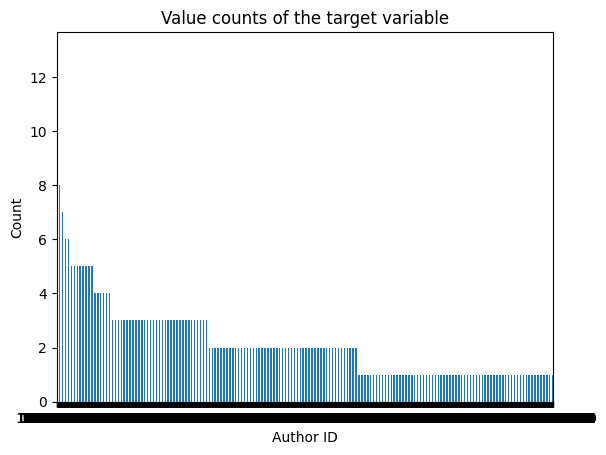

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

train_df["target"] = train_df['authorId']
train_df.target.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Author ID")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()


c:\Users\Dirk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


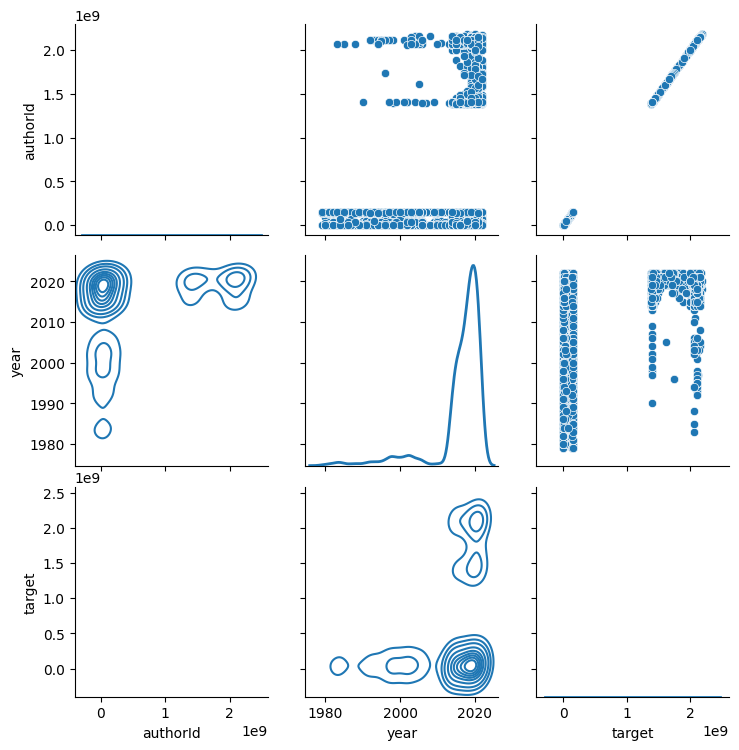

In [27]:
# PairGrid object with hue
graph = sns.PairGrid(train_df)
# type of graph for non-diagonal(upper part)
graph = graph.map_upper(sns.scatterplot)
# type of graph for non-diagonal(lower part)
graph = graph.map_lower(sns.kdeplot)
# type of graph for diagonal
graph = graph.map_diag(sns.kdeplot, lw = 2)
# to show
plt.show()

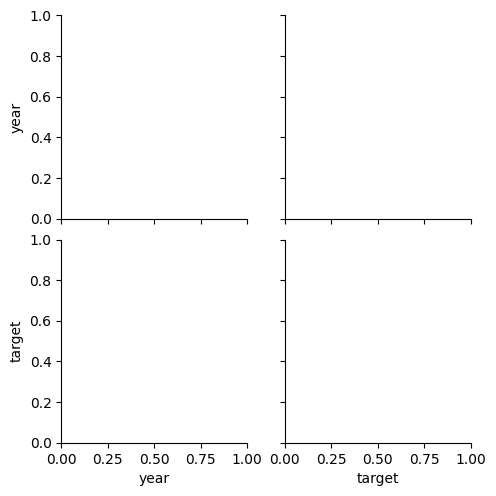

C:\Users\Dirk\AppData\Local\Temp\ipykernel_12680\4142126189.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train_df.corr()


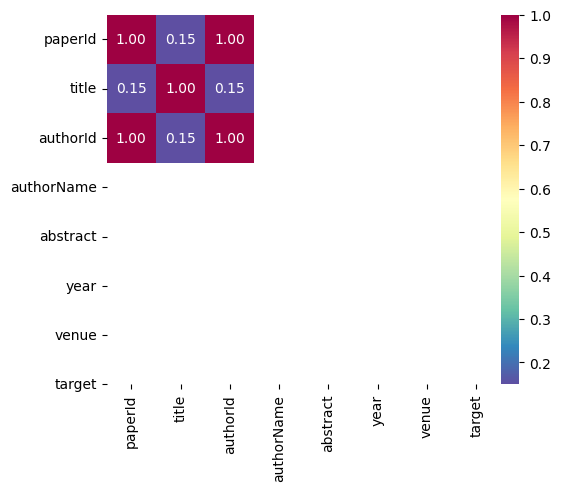

In [28]:


sns.PairGrid(train_df, hue = "authorId")
plt.show()

train_df.head()
corrmat = train_df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=train_df.columns, 
                 xticklabels=train_df.columns, 
                 cmap="Spectral_r")
plt.show()